In [173]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [174]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
# import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

0 angry
1 disgust
2 fear
3 happy
4 neutral
5 sad
6 surprise


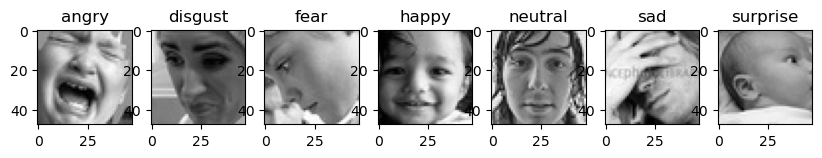

In [175]:
train_folder = 'images/train'

fig, axs = plt.subplots(1, 7, figsize=(10, 10))

class_folders = sorted(folder for folder in os.listdir(train_folder) if not folder.startswith('.'))

# Enumerate through the class folders
for id, class_folder in enumerate(class_folders):
    print(id, class_folder)

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image, cmap='gray')  # Set the color map to grayscale
    axs[id].set_title(class_folder)

plt.show()  # Display the figure


In [176]:
from PIL import Image

# Abre la imagen
img = Image.open('images/train/happy/64.jpg')

# Obtiene el tamaño de la imagen
width, height = img.size

print(f'Ancho: {width}, Alto: {height}')

Ancho: 48, Alto: 48


{'happy': 7164, 'sad': 4938, 'fear': 4103, 'surprise': 3205, 'neutral': 4982, 'angry': 3993, 'disgust': 436}


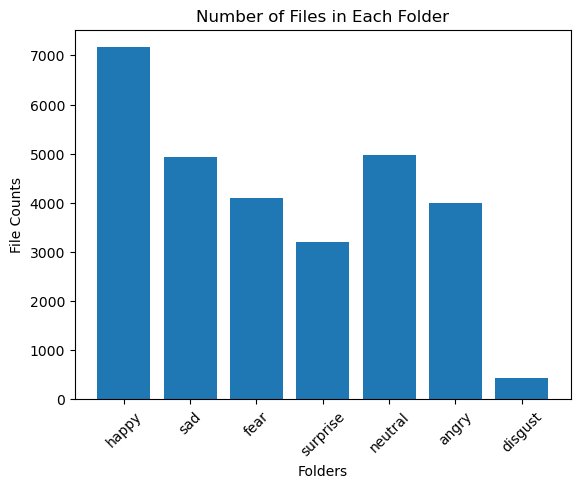

In [177]:
import os
import matplotlib.pyplot as plt

def get_folder_file_counts(parent_folder):
    folder_counts = {}
    
    for folder in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder)
        if os.path.isdir(folder_path):
            file_count = len(os.listdir(folder_path))
            folder_counts[folder] = file_count
    
    return folder_counts

def plot_bar_diagram(folder_counts):
    folders = folder_counts.keys()
    file_counts = folder_counts.values()

    plt.bar(folders, file_counts)
    plt.xlabel("Folders")
    plt.ylabel("File Counts")
    plt.title("Number of Files in Each Folder")
    plt.xticks(rotation=45)
    plt.show()


parent_folder = '/Users/matias/Documents/Posgrado/mis_trabajos/posgrado_ia/Bimestre 5/VC2/TPFINAL_CV2/images/train'
folder_counts = get_folder_file_counts(parent_folder)
print(folder_counts)
plot_bar_diagram(folder_counts)


### Undersampling

In [178]:
import os
import random
import shutil

def reducir_imagenes(origen, destino, img_num):
    carpetas = next(os.walk(origen))[1]

    if not os.path.exists(destino):
        os.makedirs(destino)

    for carpeta in carpetas:
        carpeta_actual = os.path.join(origen, carpeta)
        carpeta_nueva = os.path.join(destino, carpeta)

        if not os.path.exists(carpeta_nueva):
            os.makedirs(carpeta_nueva)

        imagenes = os.listdir(carpeta_actual)

        if len(imagenes) > img_num:
            imagenes_reducidas = random.sample(imagenes, img_num)
        else:
            imagenes_reducidas = imagenes

        for imagen in imagenes_reducidas:
            ruta_origen = os.path.join(carpeta_actual, imagen)
            ruta_destino = os.path.join(carpeta_nueva, imagen)
            shutil.copyfile(ruta_origen, ruta_destino)

    print("Reducción de imágenes completada.")





In [179]:

origen = 'images/train'
destino = 'images_reduced2/train'
img_num = 500

reducir_imagenes(origen, destino, img_num)

Reducción de imágenes completada.


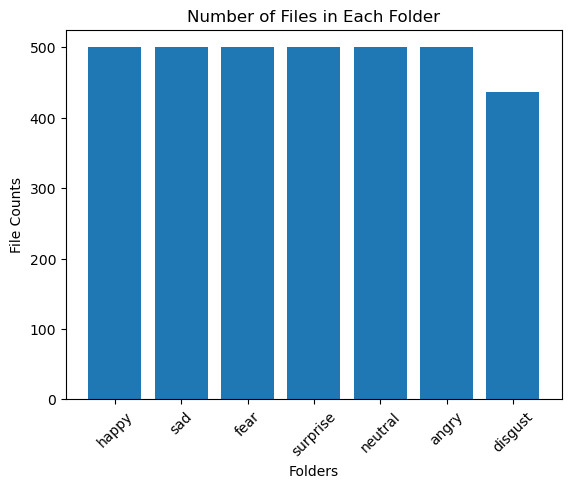

In [180]:
parent_folder = 'images_reduced2/train'
folder_counts = get_folder_file_counts(parent_folder)
plot_bar_diagram(folder_counts)

### Definimos nuestra función de entrenamiento

In [181]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        metric.to("mps")
        model.to("mps")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data.to("mps")
                train_target.to("mps")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data.to("mps")
                valid_target.to("mps")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

### Definimos nuestra arquitectura de red neuronal

In [182]:
CANTIDAD_CLASES = 7
ANCHO_IMAGENES = 48
ALTO_IMAGENES = 48

In [183]:
input_shape = (3, ANCHO_IMAGENES, ALTO_IMAGENES)
input_shape

(3, 48, 48)

In [184]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=1152, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
# if torch.cuda.is_available():
conv_model.to("mps")

# torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [185]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='images_reduced2/train', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='images/validation', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

Epoch: 1/10 - Train loss 1.946244 - Train Accuracy 0.152296 - Valid Loss 1.946384 - Valid Accuracy 0.114210
Epoch: 2/10 - Train loss 1.943160 - Train Accuracy 0.146026 - Valid Loss 1.918571 - Valid Accuracy 0.142382
Epoch: 3/10 - Train loss 1.937190 - Train Accuracy 0.170332 - Valid Loss 1.932092 - Valid Accuracy 0.174730
Epoch: 4/10 - Train loss 1.919895 - Train Accuracy 0.195795 - Valid Loss 1.971685 - Valid Accuracy 0.153378
Epoch: 5/10 - Train loss 1.893182 - Train Accuracy 0.216628 - Valid Loss 1.896903 - Valid Accuracy 0.195223
Epoch: 6/10 - Train loss 1.824158 - Train Accuracy 0.272377 - Valid Loss 1.802789 - Valid Accuracy 0.249880
Epoch: 7/10 - Train loss 1.769211 - Train Accuracy 0.295428 - Valid Loss 1.773553 - Valid Accuracy 0.266522
Epoch: 8/10 - Train loss 1.699944 - Train Accuracy 0.328897 - Valid Loss 1.736511 - Valid Accuracy 0.310074
Epoch: 9/10 - Train loss 1.620495 - Train Accuracy 0.367284 - Valid Loss 1.712287 - Valid Accuracy 0.322899
Epoch: 10/10 - Train loss 1.

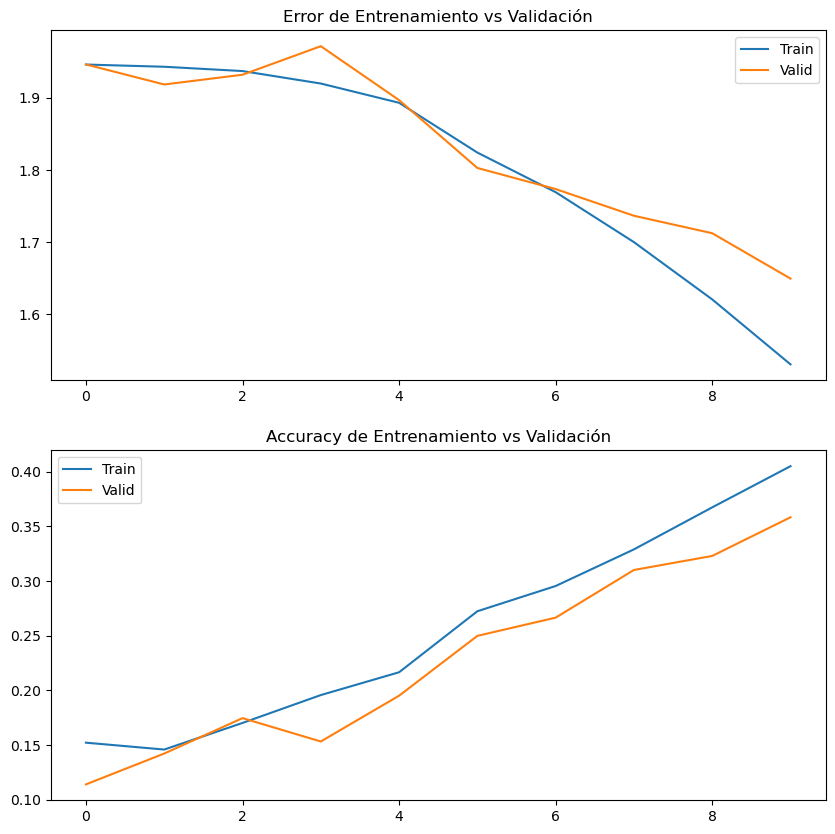

In [186]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model, 
                noaug_optimizer, 
                noaug_loss, 
                noaug_metric,
                noaug_data,
                10,
                noaug_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [187]:
import torch
import torch.nn as nn

# Create an instance of the ConvModel
loaded_model = ConvModel(CANTIDAD_CLASES)

# Set the path to save the model
model_path = "models/cv_20epochs.pth"

# Save the model
torch.save(loaded_model.state_dict(), model_path)


## Test model

In [188]:

model_path = "models/cv_20epochs.pth"
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [217]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the RGB image

folder_path = "images/validation/happy"

def get_random_file_path(folder_path):
    file_list = os.listdir(folder_path)
    if file_list:
        random_file = random.choice(file_list)
        file_path = os.path.join(folder_path, random_file)
        print(file_path)
        return file_path
    else:
        return None


images/validation/happy/13925.jpg


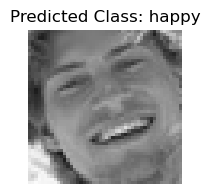

In [219]:
imagen = get_random_file_path(folder_path)
image = Image.open(imagen).convert("RGB")

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((ALTO_IMAGENES, ANCHO_IMAGENES)),
    transforms.ToTensor(),
])
preprocessed_image = transform(image)

# Add an extra dimension for the batch
preprocessed_image = preprocessed_image.unsqueeze(0)

# Move the tensor and the model to GPU if available
# if torch.cuda.is_available():
preprocessed_image = preprocessed_image.to("mps")
loaded_model = loaded_model.to("mps")

# Perform inference
with torch.no_grad():
    output = loaded_model(preprocessed_image)
    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

# Create a dictionary to map class indices to labels
class_labels = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise"
}

# Display the image
plt.figure(figsize=(2, 2))  
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Class: {class_labels[predicted_class]}")
plt.show()

